# Backtesting with itermittent refit
### Single and Multiple Independent time-series: Direct & Recursive forecasting
### Expanding Training Window & Rolling Training Window
Note: The argument needed: `refit=n`, where n is an integer. This configuration also allows the use of `fixed_train_size` to implement a rolling training window.   
Conda environment: `time-series`  
05 Jul 2024

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Single time series

In [3]:
# Load the data
data = fetch_dataset(name="h2o_exog", raw=True)
data

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


,fecha,y,exog_1,exog_2
0,1992-04-01,0.3798,0.9588,1.1660
1,1992-05-01,0.3618,0.9520,1.1179
2,1992-06-01,0.4105,0.9530,1.0679
3,1992-07-01,0.4834,0.9581,1.0974
4,1992-08-01,0.4755,0.9564,1.1222
...,...,...,...,...
190,2008-02-01,0.7618,1.5158,1.7864
191,2008-03-01,0.6494,1.5063,1.6943
192,2008-04-01,0.8279,1.5053,1.6271
193,2008-05-01,0.8163,1.4915,1.5551


In [4]:
# Data preparation
data = data.rename(columns={"fecha": "date"})
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.3798,0.9588,1.1660
1992-05-01,0.3618,0.9520,1.1179
1992-06-01,0.4105,0.9530,1.0679
1992-07-01,0.4834,0.9581,1.0974
1992-08-01,0.4755,0.9564,1.1222


In [5]:
# Check for missing values
print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


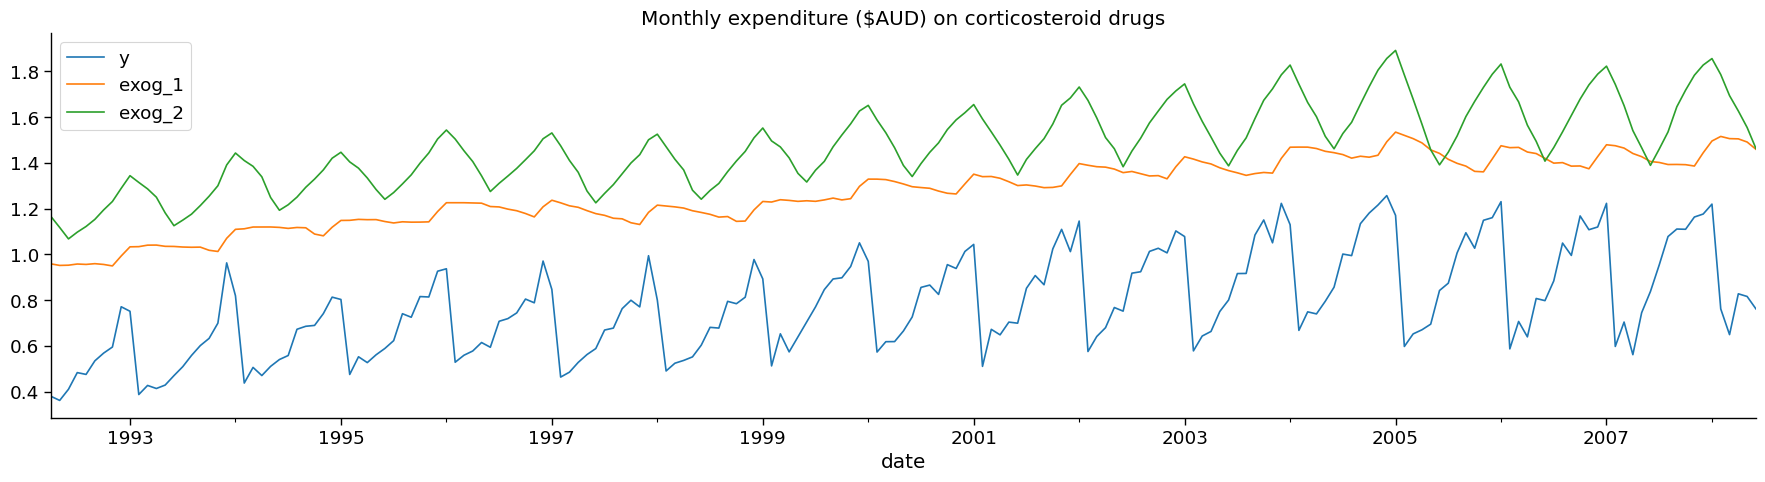

In [6]:
# Plot data
ax = data.plot()
ax.set_title("Monthly expenditure ($AUD) on corticosteroid drugs")
plt.show()

### 1.2) Direct Forecasting
In this case, we refit every 2 step. So using a window of 3 then we refit 1.

In [7]:
# Create forecaster
HORIZON = 7  # Number of steps to forecast

forecaster = ForecasterAutoregDirect(
    regressor=Ridge(alpha=1),
    lags=6,
    steps=HORIZON,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

# Number of datapoints to test over
n_backtesting = HORIZON * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Refit the model every `refit` (2) steps
refit = 2

metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    allow_incomplete_fold=True,
    fixed_train_size=False, # Expanding Training Window
    steps=HORIZON,
    metric="mean_squared_error",
    refit=refit,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MSE): {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2007-11-01 00:00:00  (n=188)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest metric (MSE): 0.012116099182152843


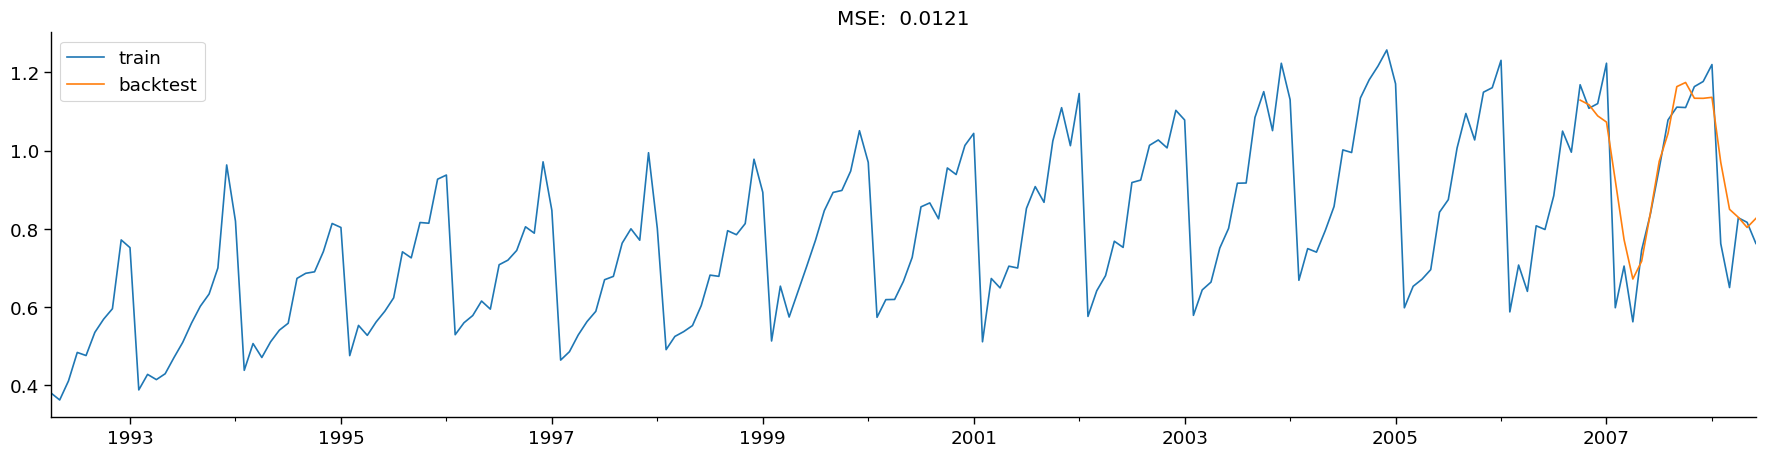

In [8]:
error_mse = mean_squared_error(
    y_true=data["y"].loc[predictions.index], y_pred=predictions
)

fig, ax = plt.subplots()
data["y"].plot(ax=ax, label="train")
predictions["pred"].plot(ax=ax, label="backtest")
ax.legend()

plt.title(f"MSE: {error_mse: .4f}")
plt.xlabel("")
plt.show()

In [9]:
# Custom metric
def custom_metric(y_true, y_pred):
    """
    Calculate the MAPE
    """
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Backtesting
# Number of datapoints to test over
n_backtesting = HORIZON * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Run backtesting
metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    allow_incomplete_fold=True,
    fixed_train_size=False,
    steps=HORIZON,
    metric=custom_metric,
    refit=refit,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MAPE): {metric: .4}%")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2007-11-01 00:00:00  (n=188)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



  0%|          | 0/3 [00:00<?, ?it/s]

Backtest metric (MAPE):  9.715%


## 2) Multiple Independent time-series

In [10]:
# Load the data
data = fetch_dataset(name="store_sales", raw=True)
data.head()

store_sales
-----------
This dataset contains 913,000 sales transactions from 2013-01-01 to 2017-12-31
for 50 products (SKU) in 10 stores.
The original data was obtained from: inversion. (2018). Store Item Demand
Forecasting Challenge. Kaggle. https://kaggle.com/competitions/demand-
forecasting-kernels-only
Shape of the dataset: (913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [11]:
# Data preprocessing

selected_store = 2
selected_items = data.item.unique()  # All items
# selected_items = [1, 2, 3, 4, 5] # Selection of items to reduce computation time

# Filter data to specific stores and products
mask = (data["store"] == selected_store) & (data["item"].isin(selected_items))
data = data[mask].copy()

# Convert `date` column to datetime
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")

# Convert to one column per time series
data = pd.pivot_table(data=data, values="sales", index="date", columns="item")

# Reset column names
data.columns.name = None
data.columns = [f"item_{col}" for col in data.columns]

# Explicitly set the frequency of the data to daily.
# This would introduce missing values for missing days.
data = data.asfreq("1D")

# Sort by time
data = data.sort_index()

data.head(4)

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,12.0000,41.0000,19.0000,21.0000,4.0000,34.0000,39.0000,49.0000,28.0000,51.0000,51.0000,55.0000,51.0000,33.0000,65.0000,15.0000,24.0000,51.0000,32.0000,35.0000,30.0000,64.0000,17.0000,45.0000,42.0000,35.0000,17.0000,45.0000,50.0000,32.0000,38.0000,26.0000,43.0000,18.0000,42.0000,64.0000,18.0000,50.0000,35.0000,20.0000,11.0000,25.0000,36.0000,12.0000,45.0000,43.0000,12.0000,45.0000,29.0000,43.0000
2013-01-02,16.0000,33.0000,32.0000,14.0000,6.0000,40.0000,47.0000,42.0000,21.0000,56.0000,56.0000,26.0000,58.0000,56.0000,71.0000,14.0000,32.0000,65.0000,34.0000,25.0000,27.0000,53.0000,24.0000,51.0000,57.0000,32.0000,24.0000,53.0000,54.0000,16.0000,37.0000,23.0000,49.0000,20.0000,46.0000,46.0000,15.0000,58.0000,26.0000,19.0000,19.0000,21.0000,35.0000,25.0000,50.0000,52.0000,13.0000,37.0000,25.0000,57.0000
2013-01-03,16.0000,46.0000,26.0000,12.0000,12.0000,41.0000,43.0000,46.0000,29.0000,46.0000,51.0000,51.0000,49.0000,57.0000,53.0000,16.0000,23.0000,63.0000,32.0000,30.0000,28.0000,65.0000,22.0000,38.0000,63.0000,44.0000,20.0000,65.0000,57.0000,26.0000,54.0000,32.0000,63.0000,23.0000,35.0000,55.0000,19.0000,52.0000,36.0000,24.0000,23.0000,20.0000,52.0000,18.0000,56.0000,30.0000,5.0000,45.0000,30.0000,45.0000
2013-01-04,20.0000,50.0000,34.0000,17.0000,16.0000,41.0000,44.0000,55.0000,32.0000,56.0000,47.0000,51.0000,53.0000,53.0000,68.0000,14.0000,29.0000,57.0000,30.0000,29.0000,27.0000,70.0000,15.0000,62.0000,56.0000,33.0000,14.0000,66.0000,64.0000,31.0000,47.0000,34.0000,52.0000,14.0000,53.0000,55.0000,28.0000,57.0000,38.0000,35.0000,15.0000,28.0000,50.0000,24.0000,57.0000,46.0000,19.0000,32.0000,20.0000,45.0000


In [12]:
# Check if any missing values introduced
data.isnull().sum().any()

False

/var/folders/fd/vdpcq4tn1v3fbxg5302hgb980000gq/T/ipykernel_53645/762125342.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.iloc[:, :4].plot(


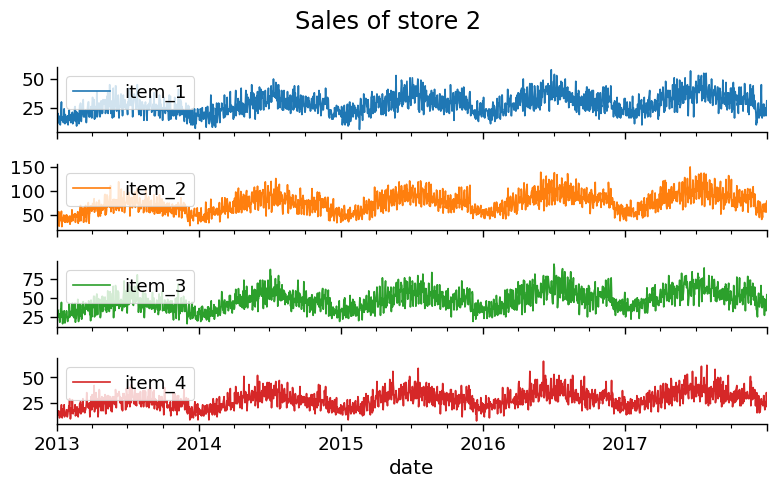

In [13]:
# Plot a subset of the time series
fig, ax = plt.subplots(figsize=(8, 5))
data.iloc[:, :4].plot(
    legend=True,
    subplots=True,
    sharex=True,
    title="Sales of store 2",
    ax=ax,
)
fig.tight_layout();

In [14]:
data["day_of_week"] = data.index.weekday

### 2.1) Multiple Independent time-series: Recursive forecasting

In [19]:
forecaster = ForecasterAutoregMultiSeries(
    regressor=Ridge(alpha=1),
    lags=31,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

# Define column names of target variables
target_cols = data.filter(like="item_").columns

# Define column names of exogenous features
exog_features = ["day_of_week"]

# Forecast horizon & number of steps to move forecast origin
steps = 7

# Number of Folds to test or windows using Nixtla nomenclature
n_backtesting = steps * 10

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Intermittent refitting steps
refit = 2

# Run backtesting
metric, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    series=data[target_cols],
    exog=data[exog_features],
    initial_train_size=initial_train_size,
    allow_incomplete_fold=True,
    steps=steps,
    metric="mean_absolute_error",
    fixed_train_size=True,  # Rolling window
    refit=refit,
    verbose=True,
    show_progress=True,
)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1756
Number of observations used for backtesting: 70
    Number of folds: 10
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2013-01-01 00:00:00 -- 2017-10-22 00:00:00  (n=1756)
    Validation: 2017-10-23 00:00:00 -- 2017-10-29 00:00:00  (n=7)
Fold: 1
    Training:   2013-01-01 00:00:00 -- 2017-10-22 00:00:00  (n=1756)
    Validation: 2017-10-30 00:00:00 -- 2017-11-05 00:00:00  (n=7)
Fold: 2
    Training:   2013-01-15 00:00:00 -- 2017-11-05 00:00:00  (n=1756)
    Validation: 2017-11-06 00:00:00 -- 2017-11-12 00:00:00  (n=7)
Fold: 3
    Training:   2013-01-15 00:00:00 -- 2017-11-05 00:00:00  (n=1756)
    Validation: 2017-11-13 00:00:00 -- 2017-11-19 00:00:00  (n=7)
Fold: 4
    Training:   2013-01-29 00:00:00 -- 2017-11-19 00:00:00  (n=1756)
    Validation: 2017-11-20 00:00:00 --

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
metric

,levels,mean_absolute_error
0,item_1,5.2630
1,item_2,8.5477
2,item_3,6.9553
3,item_4,4.6426
4,item_5,4.1919
5,item_6,10.1175
6,item_7,8.9611
7,item_8,10.8295
8,item_9,9.3994
9,item_10,11.7387


In [21]:
predictions

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
2017-10-23,24.5364,67.6541,44.6485,27.0575,18.0919,68.5929,66.9521,92.6744,58.1424,82.8233,80.2846,81.1852,98.1480,71.9538,99.3374,33.4710,40.2265,101.5550,46.7569,56.5527,50.3265,92.3802,34.5581,76.2335,92.6211,50.7460,25.9505,105.2412,76.5662,44.0143,65.5686,54.3239,81.1005,32.3448,76.9832,92.0994,33.6327,99.4351,52.9747,34.4211,24.2869,43.4850,57.4514,33.2458,89.8717,68.0091,25.2872,61.8973,31.7200,77.4566
2017-10-24,28.5868,78.1921,49.5235,29.2476,22.9750,76.8232,75.5505,103.8382,63.9942,95.1278,90.2393,89.4395,108.9366,77.1029,114.4272,37.4646,43.8907,111.4405,52.3548,60.5530,54.9306,107.1292,37.6717,86.4871,105.9647,57.7187,27.5866,117.5517,87.5204,51.6171,74.8105,62.1261,93.6023,35.3604,84.8263,102.4588,38.2934,110.2943,58.8219,38.2658,27.5466,47.8338,67.7604,38.5655,102.9274,76.3112,27.6821,66.6050,36.9746,88.8139
2017-10-25,28.7781,78.8136,50.1290,29.6739,22.2061,76.1913,77.2487,104.8095,64.4159,95.6415,90.8198,91.8544,112.8884,79.4368,111.2780,38.4278,43.9781,114.0234,51.4355,63.1905,56.1915,106.2940,39.1749,87.5733,106.4681,59.0667,29.6113,120.5957,86.1854,53.2606,77.0029,63.3673,93.8638,36.1964,87.1312,103.3334,38.4686,112.4805,59.2902,37.8929,29.2213,50.3714,68.3128,39.2611,101.6565,77.9693,28.6616,69.8355,36.2091,87.2846
2017-10-26,30.6476,81.1969,53.3885,31.5671,23.9233,83.6894,81.3372,111.9269,71.0972,100.8639,98.0413,97.5142,118.4082,84.7407,121.0476,40.0103,48.2530,121.1341,55.4578,67.4192,60.0099,114.3159,40.6970,92.7961,115.4006,65.1183,31.6608,125.8713,92.4810,56.0562,80.2900,67.8186,102.0916,39.8441,92.7951,109.4883,40.3531,119.5969,62.2747,41.9100,30.3991,52.3129,71.3615,39.7405,110.4570,82.5926,31.0168,73.0607,39.6942,93.1570
2017-10-27,34.2728,89.1682,57.4441,34.1149,26.2329,86.4488,86.6106,116.9178,74.0688,107.7564,103.2424,101.2508,124.6400,91.4340,125.2431,41.3461,48.9219,131.0575,58.7151,71.6137,62.5524,118.4886,43.8709,97.0497,120.5803,66.3389,32.8915,135.1544,98.9872,60.5675,85.3163,71.4234,105.3075,41.3914,96.3544,118.2399,42.6098,124.7245,66.3866,44.7144,32.5742,55.5534,76.2063,43.7683,113.5479,88.4043,32.9048,79.8914,42.0368,100.4382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,19.8315,54.9787,38.9729,22.7912,16.8020,58.7706,58.8170,79.5224,48.5719,75.1149,65.8840,70.4142,81.6563,59.3287,88.2602,22.7261,33.7661,87.9129,40.2594,48.3432,41.3692,80.2363,30.9880,68.9267,80.6159,47.6187,21.9716,83.8285,69.5411,40.3507,61.0550,47.3300,68.9582,28.3193,67.1427,79.7778,26.1831,82.0785,44.3037,29.2220,20.0314,36.5270,52.2510,30.1851,82.5460,59.0096,23.5912,55.4408,27.9053,68.6999
2017-12-28,22.1932,61.3723,42.6573,24.5535,19.1119,62.3441,63.2799,83.9750,52.9105,83.0010,72.1563,75.5162,88.1310,64.6733,99.5412,25.1504,37.6565,95.0209,43.3908,50.1345,44.4712,86.6011,33.7405,72.7854,86.9983,52.8639,26.4776,94.5044,75.5247,42.1205,66.0776,50.5173,76.4202,29.6745,72.4219,86.3874,27.2150,88.9098,47.6989,32.4959,22.3757,38.7399,56.7472,32.6961,88.0753,64.3312,24.7734,58.7152,29.8892,74.5338
2017-12-29,24.5411,64.5633,44.1154,26.8711,19.9507,65.4718,68.4474,90.1277,54.8280,85.9805,76.5229,79.7935,96.6873,68.0230,100.6821,26.0931,40.4757,101.6988,45.3830,53.4218,47.6527,91.6629,35.7132,77.0349,91.9996,53.8295,26.3234,98.5843,77.2849,45.6345,68.3157,54.2454,79.0130,32.2844,76.6923,91.9744,30.2653,93.8876,50.7222,34.5548,22.6609,41.5475,59.4326,36.9989,95.8639,67.1723,27.2185,62.6114,32.1799,78.7447
2017-12-30,25.7915,67.2590,50.1858,28.3262,22.4974,73.0489,73.405

In [23]:
mape_error = custom_metric(
    y_true=data[target_cols].loc[predictions.index],
    y_pred=predictions,
)

mape_error

14.616746602990666

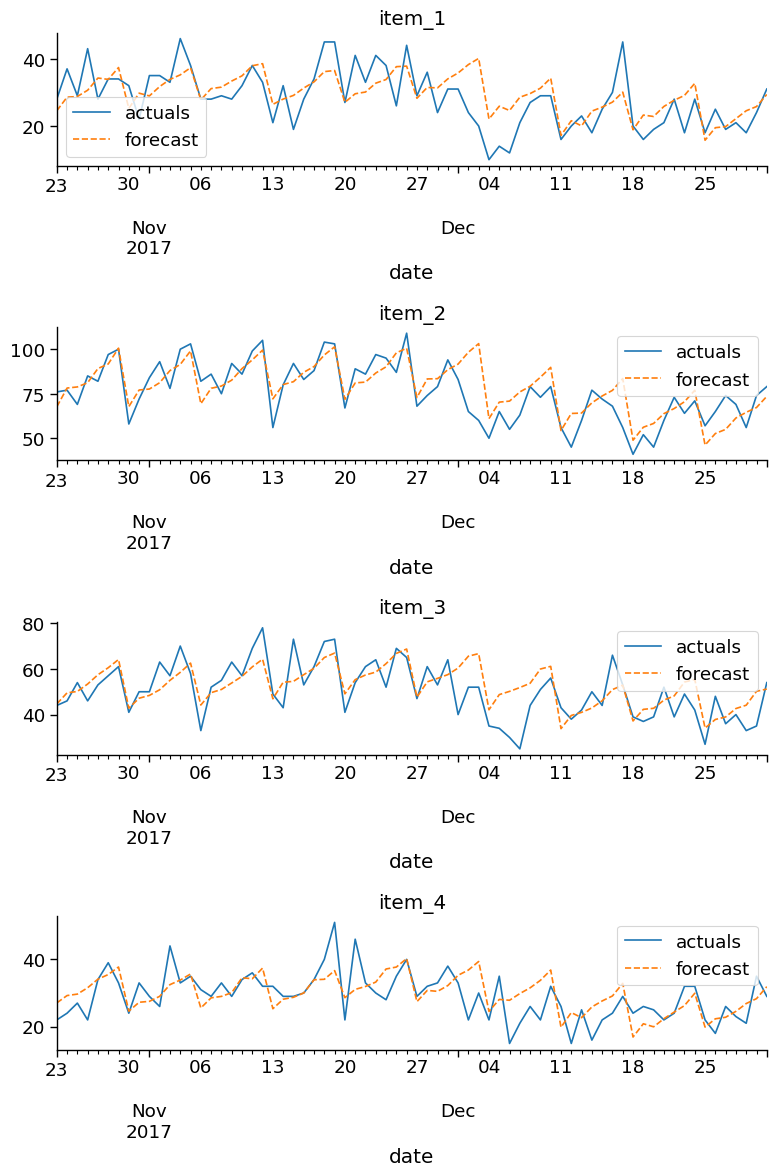

In [24]:
# Plot predictions
num_timeseries = 4
fig, axs = plt.subplots(nrows=num_timeseries, figsize=(8, 3*num_timeseries))
for i in range(4):
    timeseries = data.columns[i]
    data.iloc[-len(predictions):, i].plot(
        legend=True,
        label="actuals",
        ax=axs[i],
    )
    predictions.iloc[:, i].plot(
        legend=True,
        label="forecast",
        linestyle="--",
        ax=axs[i],
    )
    axs[i].set_title(f"{timeseries}")
    fig.tight_layout();